Lab Notebook
----------------------------

**Project Title**: Spiking dynamics of neuronal populations in the hippocampus <br>
**Project Number**: 9 <br>
**Participants**: Lyle Hopkins, Demi Brizee, Caitlin Ashcroft <br>
**Facilitators**: Dupret David (david.dupret@bndu.ox.ac.uk) and Vitor Lopes-dos-Santos (vitor.lopesdossantos@bndu.ox.ac.uk) <br>
**Department**: MRC Brain Network Dynamics Unit, Nuffield Department of Clinical Neurosciences <br>
**GitHub**: https://github.com/caitlinashcroft/Project_9

**Context** 

--------

Information processing in the brain arises from the temporally coordianted activity of populations of neurons. This project analysed data generated by simultaneously recording the activity of around 70 neurons in the mouse hippocampus using a recording probe. The key aim of this project were to examine the basic spiking properties of different cell types within the hippocampus and the relationship between the activity patterns of individual cells, groups of related cell types, and the global state of the hippocampal circuit during this recording. 

**Task 1: Data Loading**

-----

As with all data analysis projects, the first important task is to import the data you wish to analyse and the necessary packages. Our first section of code imports the following four files:

- The '.res' file, which contains the spike times for each cluster 
- The '.clu' file, which contains the cluster label for each individual spike 
- The '.des' file, which matches clusters to their corresponding cell id (aka what cell type they are)
- The 'theta.cycle' file, which contains an n x 6 array of the times that correspond to each stage of the theta oscillation of these cell

This code produces four variabless - res, clu, des, and cycles - each containing an array that correspond to information in the original file. 


In [1]:
### Loading data and necessary packages for analysis of hippocampal ephys data ##

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import scipy
import seaborn as sns

def LoadSpikeTimes(bs, MinCluId=2):

        res = pd.read_csv(bs+'.res', header=None, squeeze=True).values
        clu = pd.read_csv(bs+'.clu', squeeze=True).values
        if MinCluId is not None:
                mask = clu >= MinCluId
                clu = clu[mask]
                res = res[mask]
                
        return res,clu
    
def LoadUnits(b, par=None):
    
        '''Load "units" information (mostly from des-file).

        INPUT:
        - [b]:       <str> containing "block base"

        OUTPUT:
        - [trodes]:  <DataFrame>'''

        ## If not provided, load the par-file information
        if par is None:
                par = LoadPar(b)

        ## For each tetrode, read in its "per tetode" des-file
        trode_index = range(1, len(par['trode_ch'])+1)
        units = [pd.read_csv(b+'.des.'+str(t), header=None, names=['des']) for t in trode_index]
        units = pd.concat(units, keys=trode_index, names=['trode','trode_unit']).reset_index()

        all_trodes = pd.read_csv(b+'.des', header=None, names=['des'])
        if ~np.all(all_trodes.des == units.des):
                units.des = all_trodes.des

        ## Let the "index per tetrode" and the index of this <DataFrame> start from 2(!) instead of 0
        units['trode_unit'] += 2
        units.index += 2

        ## Return the "unit"-information as <DataFrame>
        return unitspd.read_csv(b+'.clu'+t, squeeze=True).values
    
def loadDes(b):
        # returns des matched to clu id
        des = pd.read_csv(b+'.des', header=None, names=['des'])
        des.index +=2
        return des
    
b = '/Users/caitlinashcroft/Stats/Project/Project 9/mvl10-200109' #basename 
bs = b+'_'+str(2)

res,clu = LoadSpikeTimes(bs)
cycles = np.load(bs+'.theta.cycles.7')
des = loadDes(b) # des indices correspond to the cell ids in the clu file

def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins)
  plt.xscale('log')
  print(len(bins), len(hist))

** Task 2: Data Formatting **

--------

Once the data had been uploaded, we manipulated it into a useable format to aid future analysis. In particular, we combined the res, des, and clu files into a DataFrame that matched each spike to its corresponding cluster and cell ID.

While later refinement of our analysis method rendered this DataFrame redundant, it was a useful starting point for visualising how these variables (res, des, clu) related to one another. 

In [2]:
#Set up dataframes for res, clu, and des - inspect to see makeup of data

dfres = pd.DataFrame(res)
dfclu = pd.DataFrame(clu)
dfdes = pd.DataFrame(des)


#Combine to generate dataframe containing all datasets

#Note: first to columns are 'noise' clusters 

recording_data = pd.concat([dfres,dfclu], axis = 1)
recording_data.columns = ['Res', 'Cluster']
recording_data

# To assign cell id to each cluster, match cluster in .clu file to corresponding id in .des file

cluster = []
L = []

for index, row in recording_data.iterrows():

   cluster = row['Cluster']
   id = dfdes.loc[cluster]
   value = str(id[0])
   L.append(value)

#Add cell id to dataframe

dfdes = pd.DataFrame(L)
recording_data = pd.concat([recording_data, dfdes], axis = 1)
recording_data.columns = ['Res', 'Cluster', 'Description']
recording_data

,Res,Cluster,Description
0,6,37,p1
1,21,3,b3
2,425,13,b3
3,650,3,b3
4,796,8,b3
...,...,...,...
441759,30099436,18,b3
441760,30099450,3,b3
441761,30099452,67,p1
441762,30099453,3,b3


**Task 3: Mean Firing Rates and Inter-Spike Intervals**

-----------------------------------

The first question we were interested in is how the firing rate and interspike intervals differed between neuronal subtypes. 

We decided to focus on two specific subtypes: pyramidal (P1) cells and basket (B1) cells. <br> <br>

***Firing Rate***

Firstly, to examine firing rate, we calculated the mean firing rate of each cluster within these subtypes. 



In [28]:
# Compute mean firing for p1 cells 

recording_data_p1 = []

#Extract spikes that correspond to p1 cell id

p1_cells = recording_data.loc[recording_data['Description'] == 'p1']


#identify unique clusters in p1 group

singleP1Cells = p1_cells['Cluster'].unique()

#calculate mean firing rate for each cluster 

for i in singleP1Cells:
    df = []
    df = p1_cells.loc[p1_cells['Cluster'] == i]
    samples = (max(df['Res']) - min(df['Res']))
    time = samples/20000
    meanSpike = len(df['Res'])/time
    print('The mean firing rate for Cluster ', i, 'is: ', meanSpike, 'spikes per second')

 #save spike times (in milliseconds) in an array for further analyses 

    recording_data_p1.append(np.array(df['Res']/20))

The mean firing rate for Cluster  37 is:  1.3169698280216993 spikes per second
The mean firing rate for Cluster  60 is:  1.204726848454167 spikes per second
The mean firing rate for Cluster  36 is:  1.4977924023150204 spikes per second
The mean firing rate for Cluster  52 is:  0.5588810084448916 spikes per second
The mean firing rate for Cluster  28 is:  0.09459851915478115 spikes per second
The mean firing rate for Cluster  31 is:  0.5595439122140448 spikes per second
The mean firing rate for Cluster  55 is:  3.0891177567434434 spikes per second
The mean firing rate for Cluster  58 is:  0.5950929829461311 spikes per second
The mean firing rate for Cluster  44 is:  2.8680533181221857 spikes per second
The mean firing rate for Cluster  56 is:  0.017091278983476357 spikes per second
The mean firing rate for Cluster  26 is:  0.47636833811187546 spikes per second
The mean firing rate for Cluster  53 is:  2.4598444208302634 spikes per second
The mean firing rate for Cluster  69 is:  1.81417

In [4]:
#Then compute mean firing rate for B1 cells 

#Extract spikes that correspond to b1 cell id

b1_cells = recording_data.loc[recording_data['Description'] == 'b1']

#identify unique clusters in b1 group

singleB1Cells = b1_cells['Cluster'].unique()

recording_data_b1 = []

#calculate mean firing rate for each cluster 

for i in singleB1Cells:
    df = []
    df = b1_cells.loc[b1_cells['Cluster'] == i]
    samples = (max(df['Res']) - min(df['Res'])) 
    time = samples/20000
    meanSpike = len(df['Res'])/time
    print('The mean firing rate for Cluster ', i, 'is: ', meanSpike, 'spikes per second')

    #save spike times (in milliseconds) in an array for further analyses 

    recording_data_b1.append(np.array(df['Res']/20))

The mean firing rate for Cluster  41 is:  32.01103262292616 spikes per second
The mean firing rate for Cluster  65 is:  13.481017572937699 spikes per second
The mean firing rate for Cluster  57 is:  7.555355268012541 spikes per second
The mean firing rate for Cluster  61 is:  5.956623769954366 spikes per second


These analyses demonstrate these B1 cells have a higher mean firing rate than P1 cells. This is to be expected as B1 cells, basket cells, are interneurons and are thus likely to have higher firing rates than pyramidal (P1) cells. 

***Interspike Interval***

We then chose to examine the distribution of the interspike interval (the time between spikes) for both P1 and B1 cells.

After a couple of false starts (see our project_9_analyses.ipynb file on GitHub for our early attempts to generate these graph), we were able to plot the interspike interval distributions of both p1 and b1 cells. We achived this be examining the interspike intervals of spikes occuring in set time bins. We use exactly the same bins for all clusters to enable comparison across them.

These graphs demonstrate the ISI distribution of P1 cells has two peaks: one around 2ms and another around 8ms. B1 cells, on the other hand, only displayed a single, flatter, peak in the ISI distribution around 5ms. The shaded area around the curves represents the standard error of the mean (sem) of these distributions. 

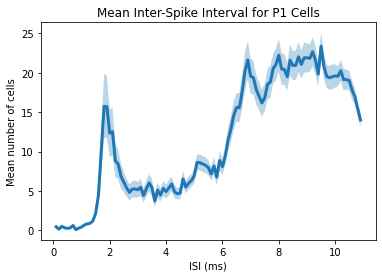

Text(0.5, 0, 'ISI (ms)')

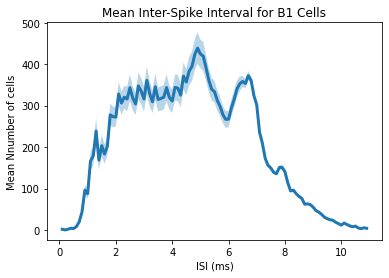

In [5]:
#Define edges of spike time bins to enable comparison across clusters

binedges = np.arange(np.log2(1),np.log2(2000),.1) 

#Examine number of clusters (67)

clus = np.unique(clu) 

#Create empty array equal in length to the number of clusters

counts = np.zeros((len(clus),len(binedges)-1)) 

#Iterate through clusters

for clui,clu_ in enumerate(clus): 

     
#Calculate spiketimes by dividing 'res' values by 20 (20,000 Hz samples dividd by 20 gives ms)

        spktimes = res[clu==clu_]/20 

#Calculate ISI for each cluster

         

        isi_ = np.log2(np.diff(spktimes)) 

         
#Populate empty counts array with interspike intervals with a given bin

        counts[clui],_ = np.histogram(isi_,binedges) 

#Create a 'mask' to identify clusters of a given cell type         

mask_p1 = des['des'].values=='p1' 
mask_b1 = des['des'].values=='b1' 

#Calculate mean ISI for this cell type

meanISI_p1 = np.mean(counts[mask_p1,:],axis=0)
meanISI_b1 = np.mean(counts[mask_b1,:],axis=0) 

#Calculate sem of ISI for this cell type

std_p1 = np.std(counts[mask_p1,:],axis=0)
std_b1 = np.std(counts[mask_b1,:],axis=0) 

n_p1 = len(meanISI_p1) 
n_b1 = len(meanISI_b1) 

sem_p1 = std_p1/np.sqrt(n_p1) 
sem_b1 = std_b1/np.sqrt(n_b1) 

#Plot mean ISI w SEM 

plt.plot(binedges[1:],meanISI_p1,lw=3)

plt.fill_between(binedges[1:],meanISI_p1-sem_p1,meanISI_p1+sem_p1,alpha=.3) 
plt.title('Mean Inter-Spike Interval for P1 Cells')
plt.xlabel('ISI (ms)')
plt.ylabel('Mean number of cells')

plt.pause(1) 

plt.plot(binedges[1:],meanISI_b1,lw=3) 
plt.fill_between(binedges[1:],meanISI_b1-sem_b1,meanISI_b1+sem_b1,alpha=.3)
plt.title('Mean Inter-Spike Interval for B1 Cells')
plt.ylabel('Mean Nnumber of cells')
plt.xlabel('ISI (ms)')

**Task 5: Theta Cycles**

-------------------------------

Theta cycles are common network phenomena in the hippocampus. These oscillations arise out of the coordinate activity of a population of hippocampal neurons. For our next task, we decided to examine how the activity of P1 and B1 cells maps onto the theta oscillations observed in these recordings (extracted from the .theta.cycles file). 

To achieve these, we created a 'theta binned activity matrix' containing the average activity of P1 and B1 cells at each stage in the theta cycle: the first ascending zero crossing, the peak, the descending zero crossing, the trough, the second ascending zero crossing, and the peak of next cycle. 

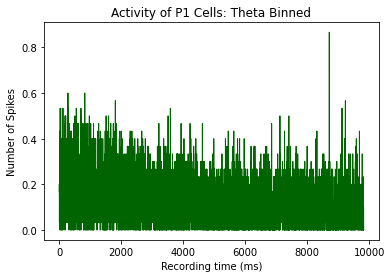

Text(0.5, 1.0, 'Activity of P1 Cells: Theta Binned')

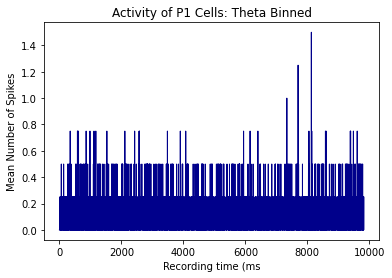

In [6]:
#####Analysis of theta cycles#### 

#Define edges of spike time bins. The bin edges for this activity matrix are defined by the peaks and troughs of the theta oscillations. 
#These values are divided by 1.25 to give the bin edge values in ms

cyedges = (cycles[:,np.array([0,4])].flatten())/1.25

#Create empty array equal in length to the number of cycles

counts = np.zeros((len(clu),len(cycles))) 

#Iterate through clusters

clus = np.unique(clu)

for clui,clu_ in enumerate(clus): 

     
# #Calculate spike times by dividing 'res' values by 20 (20,000 Hz samples dividd by 20 gives ms)

        spktimes = res[clu==clu_]/20 

         
#Populate empty counts array with spike counts within a given bin

        counts_ = np.histogram(spktimes,cyedges)[0] 
        counts_ = np.concatenate((counts_[0:-1:2], [counts_[-1]]))
        counts[clui] = counts_

# #Create a 'mask' to identify clusters of a given cell type         
mask_p1 = des.des[des.des == 'p1'].index.tolist()
mask_b1 = des.des[des.des == 'b1'].index.tolist()

#Calculate mean spikes in each bin across cell types 

mean_spks_p1 = np.mean(counts[mask_p1,:], axis = 0)
mean_spks_b1 = np.mean(counts[mask_b1,:], axis = 0)

# #Plot mean spikes for each theta bin

# First for p1 cells

binnumber = np.arange(len(cycles))

plt.plot(binnumber,mean_spks_p1,lw=1, color = 'darkgreen')
plt.xlabel('Recording time (ms)')
plt.ylabel('Number of Spikes')
plt.title('Activity of P1 Cells: Theta Binned')

#Then for b1 cells

plt.pause(1)

plt.plot(binnumber,mean_spks_b1,lw=1, color = 'darkblue')
plt.xlabel('Recording time (ms')
plt.ylabel('Mean Number of Spikes')
plt.title('Activity of B1 Cells: Theta Binned')


**Task 6: Principal Component Analysis**

--------------------------------------------------

Principal component analysis is a dimensionality reduction technique that transforms a large set of data in a smaller number of latent variables. 
We decided to perform PCA on the theta binned activity matrix of P1 cells to determine how many principal components were required to explain the majority of the variance in this data. 


([<matplotlib.axis.XTick at 0x7fd10b48a5b0>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '15')])

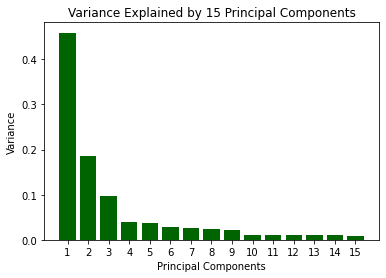

In [7]:
###PCA on P1_Cells###

#Extract spike times for p1 cells from counts 

p1_counts = counts[mask_p1,:]

# Perform PCA (assuming no of appropriate factors has already been determined)

pca = PCA(n_components = 15).fit(p1_counts)
X_pca = pca.transform(p1_counts)
PCA_components = pd.DataFrame(X_pca)

#Plot explained variance against PCs

plt.subplots()
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='darkgreen')
plt.xlabel('Principal Components')
plt.ylabel('Variance')
plt.title('Variance Explained by 15 Principal Components')
plt.xticks(np.arange(15), ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15'))

By plotting the cumulative explained variance for each principal component, we determined that 12 principal components were required to explain 95% of the variance in the p1 theta binned activity data (see below). We also generate a scree plot to examine the eigenvalues associated with each principal component. 

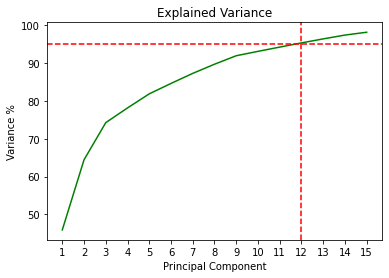

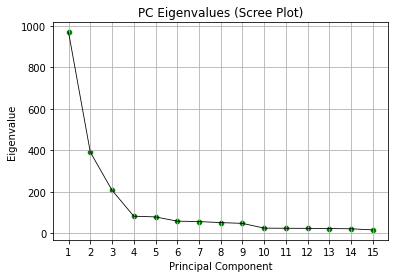

In [9]:
#Plot the % variance explained by each component 
#Examine number of PCs required to explain 95% of the variance 

plt.figure()
sns.lineplot(data = (np.cumsum(pca.explained_variance_ratio_)*100), color = 'green')
plt.xlabel('Principal Component')
plt.ylabel('Variance %') #for each component
plt.title('Explained Variance')
plt.axhline(y=95, color='r', linestyle='--')
plt.axvline(x=11, color='r', linestyle='--')
plt.xticks(np.arange(15), ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15'))
plt.show()

#Generate a screeplot plotting the eigenvalues for each PC 

plt.subplots()
sns.scatterplot(features, pca.explained_variance_, color = 'green')
plt.plot(features, pca.explained_variance_, linewidth=0.8, color = 'black')
plt.title('PC Eigenvalues (Scree Plot)')
plt.xlabel('Principal Component')
plt.xticks(np.arange(15), ('1','2','3','4','5','6','7','8','9','10','11','12', '13', '14', '15'))
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

**Task 7: General Linear Model**

-------

Our goal here was to determine the correlation between the activity of a single neuron based on the activity of the remaining neurons. In addition, by introducing surrogate runs including random ordering of the data this approach allowed us to determine biases within the dataset. 


In [27]:
# create spike count matrix 

clus = np.unique(clu)                                # finds all unique values clu resulting in list with all clu id's 
cycles_flat = cycles[:, (0,4)].flatten()/1.25 
counts_spk = np.zeros((len(clus),len(cycles_flat)-1))

for clui,clu_ in enumerate(clus):               # clui = index, clu = value in clus, for every iteration 
    spktimes = res[clu==clu_]/20                        # pair wise comparison between res and all positions were clu = clu_
    counts_spk[clui],_ = np.histogram(spktimes,cycles_flat)     # plugs histogram outpunt in 'counts' matrix at row[clui]=index 



In [11]:
# Filter data for all P1 cells 
mask_p1 = des['des'].values == 'p1'
count_spk_p1 = counts_spk[mask_p1,:]

# z-score data before GLM 
from scipy import stats
count_spk_z = stats.zscore(count_spk_p1, axis=1)                  # z-scosre per cell (=per row)

In [12]:

from scipy.stats import zscore  
from scipy import stats  

# GLM function itteration over data set 
def runreg(target,predictors): 
        setedges = np.arange(0,np.size(predictors,1)+1,np.size(predictors,1)*.2).astype(int)  # creates edges to devide all columns in set with a size 20% of the total
        target_ = np.zeros_like(target)                                                       # creates array to store target
        for seti in range(len(setedges)-1):                                                   # itterates over the sets of colums
            testingcols = np.arange(setedges[seti],setedges[1+seti])                      # all columns between two setedges
            trainingcols = np.setdiff1d(np.arange(np.size(predictors,1)),testingcols)     # all remaining columns
            trainingcols_ = trainingcols.copy() 
            regression.fit(predictors[:,trainingcols].T,target[trainingcols_].reshape(-1,1)) # fits the regression on trainingset
            target_[testingcols] = regression.predict(predictors[:,testingcols].T).squeeze() # performs the regression on testset
        r = stats.pearsonr(target,target_)[0]                                                 # correlated the predicted value with real values
        return r, target_                                                                   # return the r and predicted values(target_) 



In [14]:
# perform GLM on data

from sklearn.linear_model import LinearRegression 

# presets 
surr = 15                                                 # number of surrogate runs 
cells = np.shape(count_spk_z)[0]                            # number of cells that will be tested 
r_surr = np.zeros((cells, int(surr)))                       # empty matrix to store all surrogate r's
r_arr = np.zeros(cells)                                     # matrix to store target r's
p = np.zeros(cells)                                         # matrix to store calculated p-values

# start GLM itterating over all cells 
for celli in range(0, cells):
    regression = LinearRegression()                            # calls regression function 
    ncells = len(count_spk_z)                                  # counts number of cells in 
    targeti = celli                                               # defines target cell (tested row)
    predictoris = np.setdiff1d(np.arange(ncells),targeti)      # defines the remaining rows (done by np.setdiff1d(<define range>,<excluded value>))
    target = count_spk_z[targeti]                              # selects complete row of target cell
    predictors = count_spk_z[predictoris]                      # selects remaining rows
#testingcols = np.arange(0,int(np.size(count_spk_z,1)*.2))  # 

    r, target_ = runreg(target,predictors)                              # function to apply GLM 
    r_arr[celli] = r


    # surrogate runs to create histrogram for H0
    r_ = np.zeros(surr) 
    for i in range(len(r_)): 
            target_surr = target.copy() 
            np.random.shuffle(target_surr) 
            r_[i],_ = runreg(target_surr,predictors) 
    counts,rbins = np.histogram(r_, bins=10) 
    r_surr[celli] = r_
    p[celli] = np.mean(r_>=r) 
print('done')

done


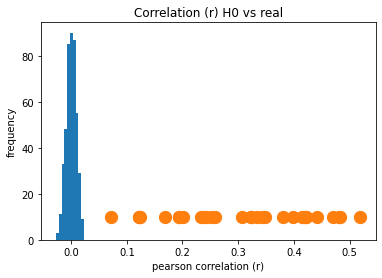

In [15]:

# plot histogram H0 vs target r's

import matplotlib.pyplot as plt

r_surrh,r_surrbins = np.histogram(r_surr)
fig, ax = plt.subplots()
ax.bar(r_surrbins[1:],r_surrh,width= r_surrbins[1]-r_surrbins[0]) 
ax.set_title('Correlation (r) H0 vs real' )
ax.set_ylabel('frequency')
ax.set_xlabel('pearson correlation (r)')
ax.scatter(r_arr,np.ones(len(r_arr))*10, s = 150)

The plot shows the H0 distrubution in blue and individual r's from the neurons tested in orange. 
The individual r's are all beyond the 95% cute off therefore reaching significance. 

Here we created a random distrubution of data per cell to create a H0 representing histogram. However this approach could also be employed to determin bias in the data, by re-ordering the data in different ways. 
This would allow to test for example population-correlation bias (here we would reorder the data in such a way that an increase in overall population activity could be determined)

** Task 9: Gaussian Mixture Model** 

-------------------------------

Gaussian Mixture models are used for representing Normally Distributed subpopulations within an overall population.
The advantage of Mixture models is that they do not require which subpopulation a data point belongs to.
It allows the model to learn the subpopulations automatically. This constitutes a form of unsupervised learning. [1]

These are advantageous over histograms as they are not restricted to arbitrary bin sizes that may not fit well with the real data.

In [16]:
clu_type = des['des'].values.tolist() # Convert to a regular python list
clu_type.insert(0, None) # Pad the front so that it lines up with the custer numbers
clu_type.insert(0, None)

In [17]:
## Group the spikes by cluster and cell type
# spike_type_dict is by cell type (combined clusters of this type)
# spike_type_dict = { 'p1': [6, 9, ...], 'p2': [...], ... }
spike_type_dict = {}
# spike_clu_dict is by individual cluster number
# spike_clu_dict = { 2: [6, 9, ...], 3: [...], ... }
spike_clu_dict = {}

# Loop through spike results and populate lists
for i in range(0, len(res)):
    if clu_type[ clu[i] ] not in spike_type_dict:
        spike_type_dict[ clu_type[ clu[i] ] ] = []
    spike_type_dict[ clu_type[ clu[i] ] ].append(res[i])
    if clu[i] not in spike_clu_dict:
        spike_clu_dict[ clu[i] ] = []
    spike_clu_dict[ clu[i] ].append(res[i])

In [18]:
## List clusters per type
# type_clu_list = { 'p3': [2, 4, 5, ...], ... }
type_clu_list = {}
# Loop through the cluster cell types
for i in range(2, len(clu_type)):
    if clu_type[i] not in type_clu_list:
        type_clu_list[ clu_type[i] ] = []
    type_clu_list[ clu_type[i] ].append(i)

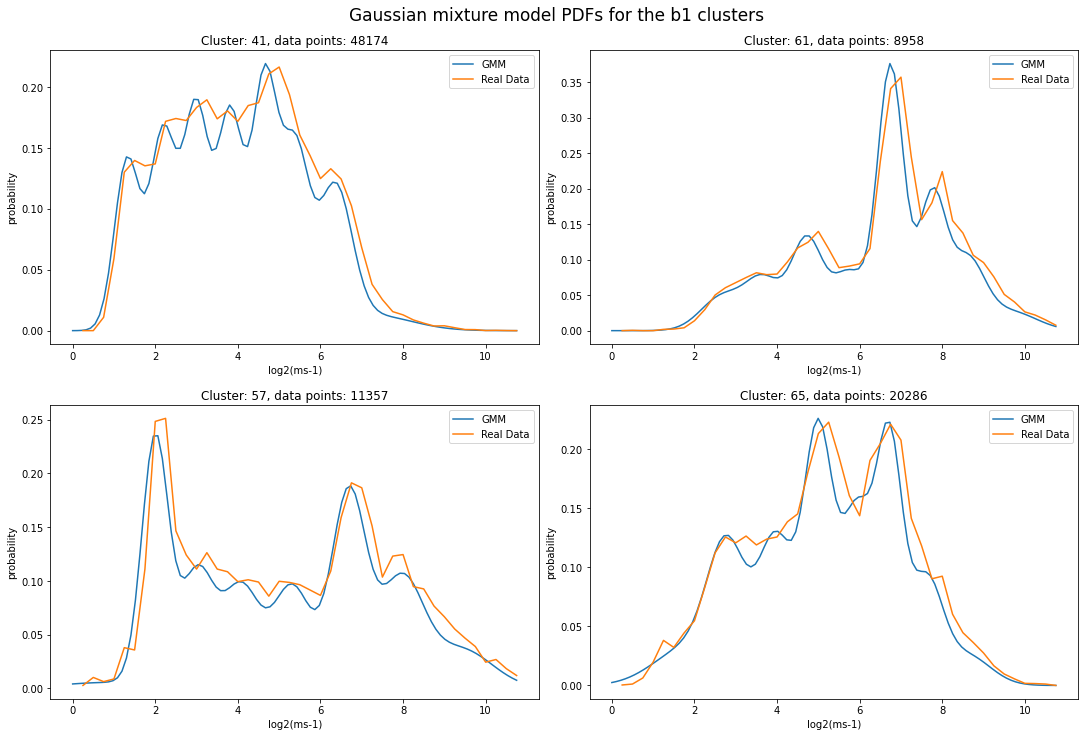

In [25]:
## Graph gaussian mixture models for the each p1 cluster

from sklearn import mixture

# Cell type
cell_type = 'p1'

# Set up the plot for two column subplots
fig_rows = round(len(type_clu_list[cell_type])/2 + 0.1)
fig_height = fig_rows*5
# Limit the height if we have a lot of plots
if fig_height > 50:
    fig_height = 50
fig, axs = plt.subplots(fig_rows,2,figsize=(15,fig_height))
fig.suptitle('Gaussian mixture model PDFs for the %s clusters' % cell_type, y=1, fontsize=17)
fig.tight_layout(h_pad=4, w_pad=2)
x,y = 0,0

# Loop through all of the clusters for this cell type
for clusterid in type_clu_list[cell_type]:
    if len(spike_clu_dict[clusterid]) < 4:
        continue
    spktimes = np.array(spike_clu_dict[clusterid]) / 20 # Convert to ndarray for /20
    isi = np.diff(spktimes)
    isi = isi[isi!=0] # Strip out any 0s as they cause problems
    isilog = np.log2(isi)

    # Split the data into histogram bins
    counts,bcounts = np.histogram(isilog,np.arange(np.log2(1),np.log2(2000),.25))

    # Create the gaussian mixture object with 8 components
    clf = mixture.GaussianMixture(n_components=8, covariance_type='full')

    # Train the model on our data (adjust the array to column form)
    clf.fit(isilog[:,None])

    gmm_x = np.linspace(bcounts.min(),bcounts.max(),100) # Prepare x co-ordinates
    gmm_y = pow(np.sqrt(2)*2,clf.score_samples(gmm_x.reshape(-1,1))) # Generate y from the model

    axs[x,y].plot(gmm_x,gmm_y, label='GMM') # Plot the gaussian mixture

    # Adjust the counts so that the area under the curve = 1
    if (np.sum(counts)*np.diff(bcounts)[0]):
        pcounts = counts/(np.sum(counts)*np.diff(bcounts)[0])
    else:
        pcounts = counts

    axs[x,y].plot(bcounts[1:],pcounts, label='Real Data') # Plot the actual data

    # Label, etc.
    axs[x,y].set_title("Cluster: %d, data points: %d" % ( clusterid, len(spike_clu_dict[clusterid]) ) )
    axs[x,y].legend (loc = 1)
    axs[x,y].set_ylabel("probability")
    axs[x,y].set_xlabel("log2(ms-1)")

    # Adjust to the next plot location
    x += 1
    if x >= fig_rows:
        x = 0
        y += 1
    if y > 1:
        y = 0


Text(0.5, 0, 'log2(ms-1)')

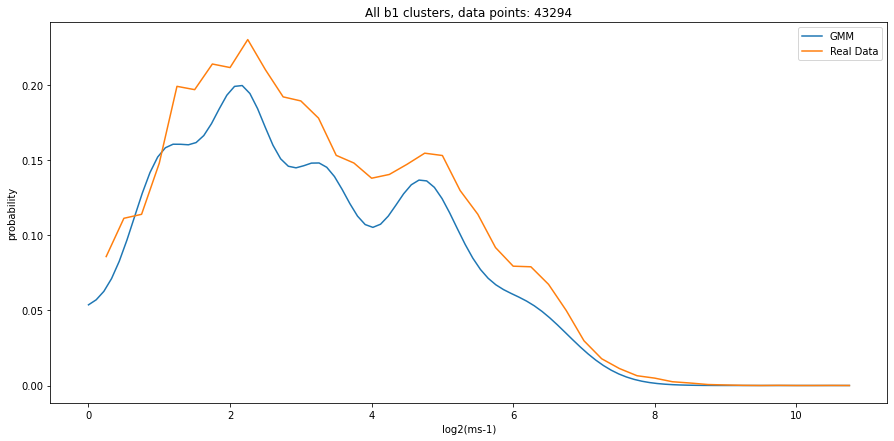

In [26]:
# Graph for combined clusters for a cell type
spktimes = np.sort(np.array(spike_type_dict[cell_type]))/20 # Convert to ndarray for /20
isi = np.diff(spktimes)
isi = isi[isi!=0] # Strip out any 0s as they cause problems
isilog = np.log2(isi)

# Split the data into histogram bins
counts,bcounts = np.histogram(isilog,np.arange(np.log2(1),np.log2(2000),.25))

# Create the gaussian mixture object with 8 components
clf = mixture.GaussianMixture(n_components=7, covariance_type='full')

# Train the model on our data (adjust the array to column form)
clf.fit(isilog[:,None]) # Fit the array in column form

x = np.linspace(bcounts.min(),bcounts.max(),100) # Prepare x co-ordinates
prd = pow(np.sqrt(2)*2,clf.score_samples(x.reshape(-1,1))) # Generate y from the model

plt.figure(figsize=(15,7))
plt.plot(x,prd, label='GMM') # Plot the gaussian mixture

# Adjust the counts so that the area under the curve = 1
pcounts = counts/(np.sum(counts)*np.diff(bcounts)[0])
plt.plot(bcounts[1:],pcounts, label='Real Data') # Plot the actual data

# Label, etc.
plt.legend (loc = 1)
plt.title("All %s clusters, data points: %d" % ( cell_type, len(spike_type_dict['p1']) ) )
plt.ylabel("probability")
plt.xlabel("log2(ms-1)")

[1] https://www.mygreatlearning.com/blog/gaussian-mixture-model/

**Conclusions and Future Directions**

----------------

*Key Findings*

- P1 and B1 cells differ in their mean firing rates. This observation is consistent with our understanding of the firing patterns of pyramidal cells and interneurons. 
- The interspike interval distribution of P1 and B1 cells are notably different. The P1 ISI distribution display two peaks, the B1 distribution display only one. 
-  B1 cells display a flatter distribution of theta binned activity (spiking activity binned with respect to different points in the theta cycle) than P1 cells. 
- 95% of the variance in the P1 cell theta binned activity can be explained using 12 principal components. 
- The correlation between the activity of P1 cells is significantly different from the expected H0 distribution (p < 0.001). However, this model didn't acccount for potential biases in these correlations e.g all cells responding to changes in the global network state. 
- The gaussian mixture model can be used to make predictions about the behaviour of individual clusters. However, this requires a large amount of data - the predictions were noticably less accurate for clusters with less data (i.e fewer spikes).



*Future Work*

A significant proportion of this project was based on describing and visualising the dataset provided. As such, there are many further analyse that could be performed to draw conclusions about the relationshio between different cells types and hippocampal network activity. 

Such further analyses could include: 

- Extract the basic firing properties (mean firing rate, ISI etc) for every cell type in this dataset and test to see if the differences between these are statisitcally significant
- Use the generalised linear model to examine autocorrelation and population bias for each cell.
- The gaussian mixed model requires a large amount of data. Performing additional experiments that produce more data could be valuable as this is likely to ensure the model is trained more succesfully.

Possible additional experiments: 

- Use a similar recording protocol to examine individual neuronal and network activity in the hippocampus in mice performing a behvioural task. The resulting data could be used to examine how the activity of different populations of neurons correlate with the observed behaviour. 

